# Climate Analysis and Exploration

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

## Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station
# ins = inspect(engine)
# ins.get_columns('Measurement')

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Exploratory Climate Analysis

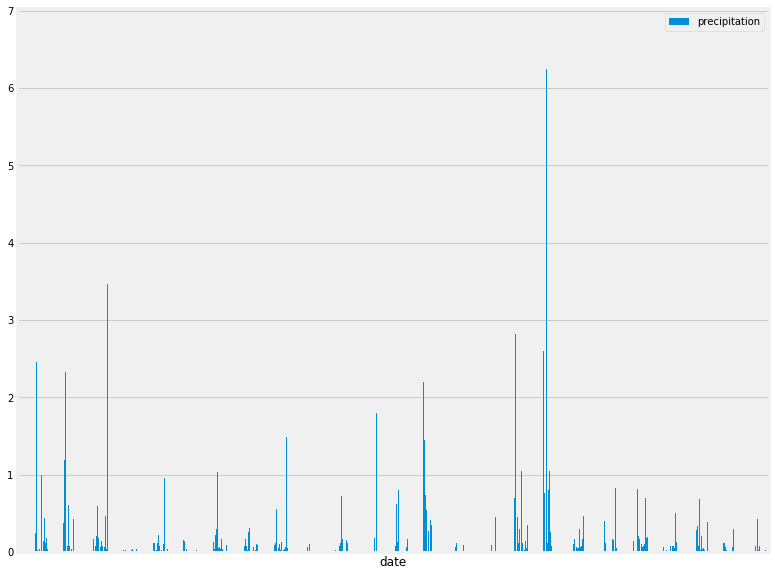

In [10]:
# get latest date
latestdate = session.query(func.max(Measurement.date)).first()
for date in latestdate:
    daten = dt.datetime.strptime(date,'%Y-%m-%d').date()
# find what one year before the latest date is
oneyearbefore = daten - dt.timedelta(days=365)
# query data for the data from the last year
lastyeardata = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date >= oneyearbefore).all()
# put data into dataframe
lastyearDF = pd.DataFrame(lastyeardata, columns=['date','precipitation']).sort_values(by='date').set_index('date')

plt.figure(figsize=(12, 10))
lastyearDF.plot.bar(ax = plt.gca())
plt.xlabel('date')
plt.xticks([], [])
plt.show()


![precipitation](Images/precipitation.png)

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
lastyearDF.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [12]:
# Design a query to show how many stations are available in this dataset?
numstations = session.query(func.count(Station.id)).first()
numstations

(9)

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
activitybystation = session.query(Measurement.station, func.count(Measurement.date)).\
    group_by(Measurement.station).order_by(func.count(Measurement.date).desc()).all()
mostactivestation = activitybystation[0].station
print(f"The most active station is {mostactivestation}")
activitybystation

The most active station is USC00519281


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
stationactivity = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
    filter(Measurement.station == mostactivestation).first()
stationactivity

(54.0, 85.0, 71.66378066378067)

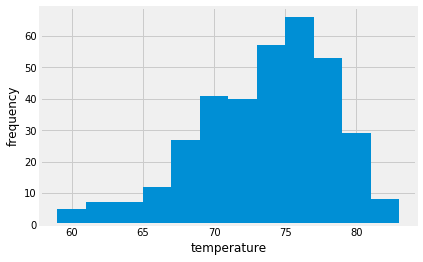

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
stationactivity12mo = session.query(Measurement.tobs).\
    filter(Measurement.station == mostactivestation, Measurement.date >= oneyearbefore).all()
activitylist = [np.ravel(stationactivity12mo)]
plt.hist(activitylist,bins=12)
plt.ylabel('frequency')
plt.xlabel('temperature')
plt.show()

![precipitation](Images/station-histogram.png)

## Temperature Analysis I

In [16]:
from scipy import stats

In [17]:
# get temps in June and December
juntempsavg = session.query(func.avg(Measurement.tobs)).\
    filter(func.strftime("%m", Measurement.date) == "06").group_by(Measurement.station).all()
juntempsavglst = np.ravel(juntempsavg)

dectempsavg = session.query(func.avg(Measurement.tobs)).\
    filter(func.strftime("%m", Measurement.date) == "12").group_by(Measurement.station).all()
dectempsavglst = np.ravel(dectempsavg)

In [18]:
# compute paired t-test since samples are related (same place, different time)
stats.ttest_rel(juntempsavglst,dectempsavglst)

Ttest_relResult(statistic=6.95696617044294, pvalue=0.00011759380231523222)

This result is statistically significant with a pvalue of less than .01

## Temperature Analysis II

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
triptemps = calc_temps('2017-02-10',"2018-02-10")[0]
triptemps

(58.0, 75.18744551002615, 87.0)

Text(0, 0.5, 'Temp (F)')

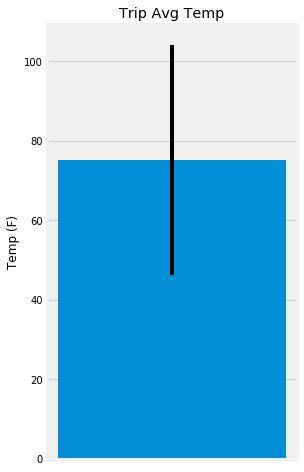

In [21]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
errorbar = triptemps[2] - triptemps[0]
plt.figure(figsize=(4,8))
plt.bar(x=[1], height=triptemps[1], yerr=errorbar)
plt.xticks([],[])
plt.title('Trip Avg Temp')
plt.ylabel("Temp (F)")